# Ensemble

## Import libs

In [1]:
import sys

from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings(action='ignore')

In [3]:
# 경로설정

CWD = Path.cwd()
WORKSPACE_PATH = CWD.parent
COMMON_PATH = WORKSPACE_PATH / 'common'
DATA_PATH = WORKSPACE_PATH / 'data'
ALPHAS_PATH = WORKSPACE_PATH / 'alphas'
FONT_PATH = COMMON_PATH / 'fonts' / 'NanumGothic.ttf'

JAEPIL_PATH = WORKSPACE_PATH / 'jaepil'
BOBAE_PATH = WORKSPACE_PATH / 'bobae'
GARAM_PATH = WORKSPACE_PATH / 'garam'

In [4]:
font_prop = font_manager.FontProperties(fname=FONT_PATH)
print( font_prop.get_name() )

font_manager.fontManager.addfont(str(FONT_PATH))
rc('font', family=font_prop.get_name())

NanumGothic


In [5]:
sys.path.append(str(COMMON_PATH))

In [6]:
import fn_loader as fn
import fn_config as fncfg
import gaps_config as gcfg

from validator import *
from backtest import Backtest
from ensemble import EqualWeight, AdaptiveWeight

## Import data

In [7]:
# loader 생성 (데이터 로드 + multi index로 전처리)
# use_alias=True 일 경우 긴 ETF명 대신 축약한 단어 사용
pricevolume1 = fn.FnDataLoader('DBGAPS2024_pricevolume1_240826.xlsx', use_alias=True)  

In [8]:
return_df = pricevolume1.get_data('return') / 100 # 

## Load alphas

- 재필 mvo
- 보배 rp

In [9]:
jp_mvo = pd.read_pickle(ALPHAS_PATH / 'jaepil_mvo.pkl')

In [10]:
asset_order = jp_mvo.columns

In [11]:
return_df = return_df.reindex(columns=asset_order)

# TODO: 이것 빠지면 오류 바로 남. Alpha나 Ensemble에서 자체 검증 후 바꿔줄 수 있도록 만들기.

In [12]:
bb_rp = pd.read_excel(BOBAE_PATH / '포트폴리오비중_20240722.xlsx', index_col=0)
bb_rp.index = pd.to_datetime(bb_rp.index)
bb_rp.drop('cash', axis=1, inplace=True) # cash 대신 mmf 쓸꺼니까 삭제. 

# 하지만 cash의 weight는 1%~50% 사이이다. 즉, weight sum이 1이 아닌 0.99가 되어야 함. 
bb_rp = bb_rp[asset_order].copy() # column 순서를 맞춰준다. 필수적. 

In [13]:
bb_daily_index = pd.date_range(start=bb_rp.index[0], end=bb_rp.index[-1], freq='D')

# Reindex the DataFrame to daily dates
bb_rp = bb_rp.reindex(bb_daily_index) # TODO: Alpha creation 시 index 일치시켜야 함. 특히 monthly를 daily로 바꾸고 ffill


In [14]:

bb_rp = bb_rp[bb_rp.index.isin(jp_mvo.index)].ffill() # 거래일 고려도 필요함. 

In [15]:
bb_rp = ConstraintHandler.apply_constraints(
    weights_df=bb_rp,
    objective_function=obj_mse
).copy() # 최대한 본래 weight를 안건드리며 weight를 재조정한다. 

In [16]:
# Make alpha instances

jp_mvo_alpha = Alpha('jaepil', jp_mvo)
bb_rp_alpha = Alpha('bobae', bb_rp)


In [17]:
alphas = [jp_mvo_alpha, bb_rp_alpha]

## Combine alphas

In [18]:
ew = EqualWeight(
    alphas=alphas,
    returns_df=return_df,
)

In [19]:
ew_alpha = ew.mix()

In [20]:
ew_back = Backtest(ew_alpha, return_df)

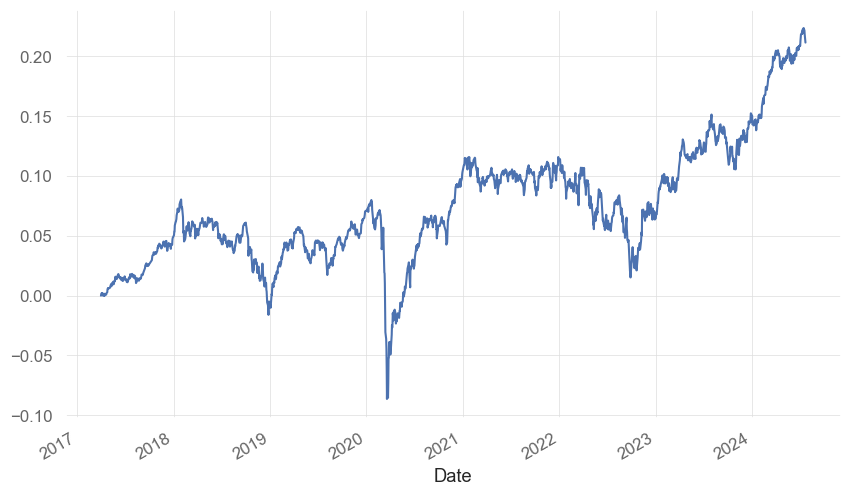

In [21]:
ew_back.plot_cum_return()

In [22]:
adw = AdaptiveWeight(
    alphas=alphas,
    returns_df=return_df,
)

In [23]:
adw_alpha = adw.mix() 

In [24]:
adw_back = Backtest(adw_alpha, return_df)

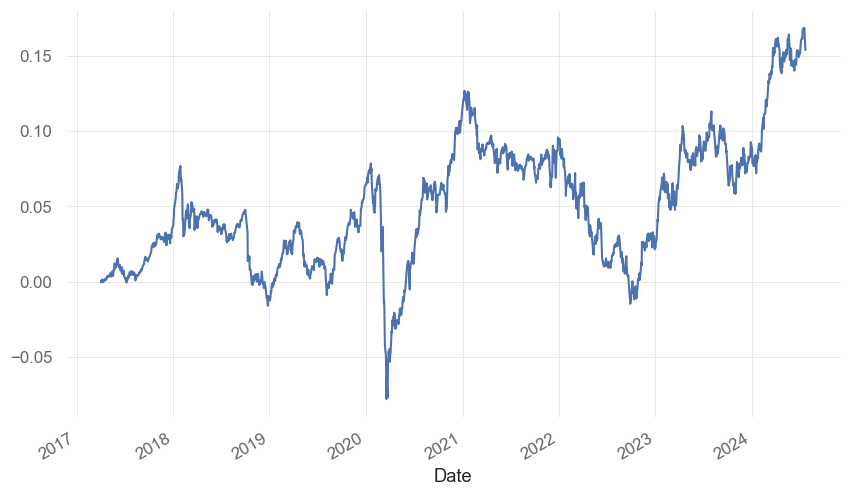

In [25]:
adw_back.plot_cum_return()

In [26]:
stats = [
    'sharpe',
    'avg_return',
    'max_drawdown',
    'win_rate',
]

for stat in stats:
    print(f'{stat}: {adw_back.get_stat(stat)}')

sharpe: 0.38132292845493526
avg_return: 8.612563384871092e-05
max_drawdown: -0.14492954833563565
win_rate: 0.5557413600891862


In [30]:
for stat in stats:
    print(f'{stat}: {ew_back.get_stat(stat)}')

sharpe: 0.5120941019494555
avg_return: 0.00011300029997717698
max_drawdown: -0.15429482185921206
win_rate: 0.5537604456824513


In [27]:
jp_mvo_back = Backtest(jp_mvo_alpha, return_df)
bb_rp_back = Backtest(bb_rp_alpha, return_df)

In [28]:
for stat in stats:
    print(f'{stat}: {jp_mvo_back.get_stat(stat)}')

sharpe: 0.6905110157835548
avg_return: 0.00010840825697435612
max_drawdown: -0.09729368901886104
win_rate: 0.5511853448275862


In [29]:
for stat in stats:
    print(f'{stat}: {bb_rp_back.get_stat(stat)}')

sharpe: 0.39118796995734206
avg_return: 0.00011611415824985837
max_drawdown: -0.21257029978099584
win_rate: 0.5526462395543176
